# Generate cerebra_data
Notebook to generate cerebra_data folder (cerebra_atlas_python/cerebra_data)

**Requirements:**
- FreeSurfer (https://surfer.nmr.mgh.harvard.edu/)
- Datasets:
    - [CerebrA](https://gin.g-node.org/anamanera/CerebrA/src/master/): $CEREBRA_DIR
    - [ICBM 2009c Nonlinear Symmetric [NIFTI]](https://nist.mni.mcgill.ca/icbm-152-nonlinear-atlases-2009/): $ICBM_DIR
- Install requirements.txt

In [1]:
# Notebook setup
%load_ext autoreload
%autoreload 2
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
# Imports
import os
import os.path as op
import logging
import mne
import numpy as np
from cerebra_atlas_python.utils import inspect_img,setup_logging,get_volume_ras

In [4]:
## Constants

# Datasets
ICBM_DIR = op.join(os.getenv("DATASETS_DIR"),"ICBM_2009c_Nonlinear_Symmetric/mni_icbm152_nlin_sym_09c_nifti")
CEREBRA_DIR = op.join(os.getenv("DATASETS_DIR"),"Cerebra")

# FreeSurfer
FS_SUBJECTS_DIR = os.getenv("SUBJECTS_DIR")
NEW_SUBJECT_NAME = "icbm152" # Used by FreeSurfer
NEW_FS_SUBJECT_DIR = op.join(FS_SUBJECTS_DIR,NEW_SUBJECT_NAME)
BEM_DIR = op.join(NEW_FS_SUBJECT_DIR, "bem")

# Output dir
CEREBRA_DATA_DIR = "../cerebra_atlas_python/cerebra_data"
CEREBRA_DATA_FS_DIR = op.join(CEREBRA_DATA_DIR, "FreeSurfer")
CEREBRA_DATA_ICBM152_DIR = op.join(CEREBRA_DATA_FS_DIR, "subjects", NEW_SUBJECT_NAME)
CEREBRA_DATA_MNE_DIR = op.join(CEREBRA_DATA_DIR, "MNE")

LABEL_DETAILS_PATH = op.join(CEREBRA_DATA_DIR,"label_details.csv")

In [5]:
setup_logging("INFO")

In [6]:
# FREESURFER must be installed
!freesurfer --version


FreeSurfer is a set of tools for the analysis and visualization
of structural and functional brain imaging data. FreeSurfer
also refers to the structural imaging stream within the
FreeSurfer suite.

Users should consult the online documentation available at:

  http://surfer.nmr.mgh.harvard.edu

Alternatively, the 'recon-all' command help-text provides
adequate information to begin processing subject data, such
as the sample subject 'bert' found in the 'freesurfer/subjects'
directory.  Type 'recon-all --help' to view this help-text.

Direct comments and questions to:

  freesurfer@nmr.mgh.harvard.edu

You are running this version of FreeSurfer:

  freesurfer-linux-ubuntu22_x86_64-7.4.1-20230614-7eb8460



# 1) Use Freesurfer to perform cortical reconstruction and generate Boundary Element Model (BEM) surfaces

#### Run fs recon-all

In [7]:
if op.exists(NEW_FS_SUBJECT_DIR):
    logging.info("%s FreeSurfer subject already exists, skipping recon-all", NEW_SUBJECT_NAME)
else:
    logging.info("Running recon-all for %s", NEW_SUBJECT_NAME)
    !recon-all -subjid $NEW_SUBJECT_NAME -i $ICBM_DIR/mni_icbm152_t1_tal_nlin_sym_09c.nii -all
!mkdir -p $CEREBRA_DATA_ICBM152_DIR/mri
!cp $NEW_FS_SUBJECT_DIR/mri/T1.mgz $CEREBRA_DATA_ICBM152_DIR/mri/T1.mgz
!cp $NEW_FS_SUBJECT_DIR/mri/wm.asegedit.mgz $CEREBRA_DATA_ICBM152_DIR/mri/wm.mgz

 [INFO] 2024-04-11 21:04:22.731 3589068124 - <module>: icbm152 FreeSurfer subject already exists, skipping recon-all


#### Run mne.bem.make_watershed_bem 
BEM surfaces were generated using the FreeSurfer watershed algorithm through MNE's `mne.bem.make_watershed_bem` and then manually edited so that all inner surfaces are contained within the outer surfaces as explained [here](https://mne.tools/stable/auto_tutorials/forward/80_fix_bem_in_blender.html).

In [8]:
NEW_FS_SUBJECT_DIR

'/home/carlos/Datasets/subjects/icbm152'

In [9]:
if op.exists(BEM_DIR):
    logging.info("BEM surfaces for subject %s already exist, skipping make_watershed_bem", NEW_SUBJECT_NAME)
else: 
    logging.info("Running make_watershed_bem for %s", NEW_SUBJECT_NAME)
    mne.bem.make_watershed_bem(NEW_SUBJECT_NAME)
!mkdir -p $CEREBRA_DATA_ICBM152_DIR/bem
!cp $NEW_FS_SUBJECT_DIR/bem/* $CEREBRA_DATA_ICBM152_DIR/bem

 [INFO] 2024-04-11 21:04:28.414 3388132949 - <module>: BEM surfaces for subject icbm152 already exist, skipping make_watershed_bem


cp: -r not specified; omitting directory '/home/carlos/Datasets/subjects/icbm152/bem/do_not_cpt'
cp: -r not specified; omitting directory '/home/carlos/Datasets/subjects/icbm152/bem/watershed'


<div style="display:flex;align-items:center;justify-content:center;background-color:black;padding:25px;flex-direction:column"><img src="../images/bem_manual_edit.png" alt="BEM MANUAL EDIT" width=50%></img><br/><small>Manual editing of BEM surfaces produced by make_watershed_bem (FreeSurfer's mri_watershed)</small></div>

# 2) Convert CerebrA volume to T1w scan coordinate frame

In [12]:
!mri_convert $CEREBRA_DIR"/CerebrA.nii" $CEREBRA_DIR"/CerebrA.mgz"
!mri_vol2vol --mov $CEREBRA_DIR"/CerebrA.mgz" --o $CEREBRA_DATA_DIR"/CerebrA_in_t1.mgz" --regheader --targ $CEREBRA_DATA_ICBM152_DIR/mri/T1.mgz --interp nearest

mri_convert /home/carlos/Datasets/Cerebra/CerebrA.nii /home/carlos/Datasets/Cerebra/CerebrA.mgz 
reading from /home/carlos/Datasets/Cerebra/CerebrA.nii...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
writing to /home/carlos/Datasets/Cerebra/CerebrA.mgz...
movvol /home/carlos/Datasets/Cerebra/CerebrA.mgz
targvol ../cerebra_atlas_python/cerebra_data/FreeSurfer/subjects/icbm152/mri/T1.mgz
outvol ../cerebra_atlas_python/cerebra_data/CerebrA_in_t1.mgz
invert 0
tal    0
talres 2
regheader 1
noresample 0
interp  nearest (0)
precision  float (3)
Gdiag_no  -1
Synth      0
SynthSeed  1712880798

Computing registration based on scanner-to-scanner

Final tkRAS-to-tkRAS Matrix is:
-1.00000   0.00000   0.00000   0.00000;
 0.00000   0.00000   1.00000   0.00000;
 0.00000  -1.00000   0.00000   0.00000;
 0.00000   0.00000   0.00000   1.00000;


Vox2Vox Matrix is:
-1.00000   0.00000   0.00000   224.50000;
 0.00000   0.00000   1.00000  -13.50000;
 0.0000

##### Plot alignment

ax.get_xlim()=(0.0, 256.0)
fixed_value= 126 cerebra_volume.shape= (256, 256, 256)
ax.get_xlim()=(0.0, 256.0)
fixed_value= 145 cerebra_volume.shape= (256, 256, 256)
ax.get_xlim()=(0.0, 256.0)
fixed_value= 108 cerebra_volume.shape= (256, 256, 256)
fixed_value= 126 cerebra_volume.shape= (256, 256, 256)
fixed_value= 145 cerebra_volume.shape= (256, 256, 256)
fixed_value= 108 cerebra_volume.shape= (256, 256, 256)


(<Figure size 1500x1500 with 4 Axes>,
 array([[<Axes: xlabel='Y', ylabel='Z'>, <Axes: xlabel='X', ylabel='Z'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

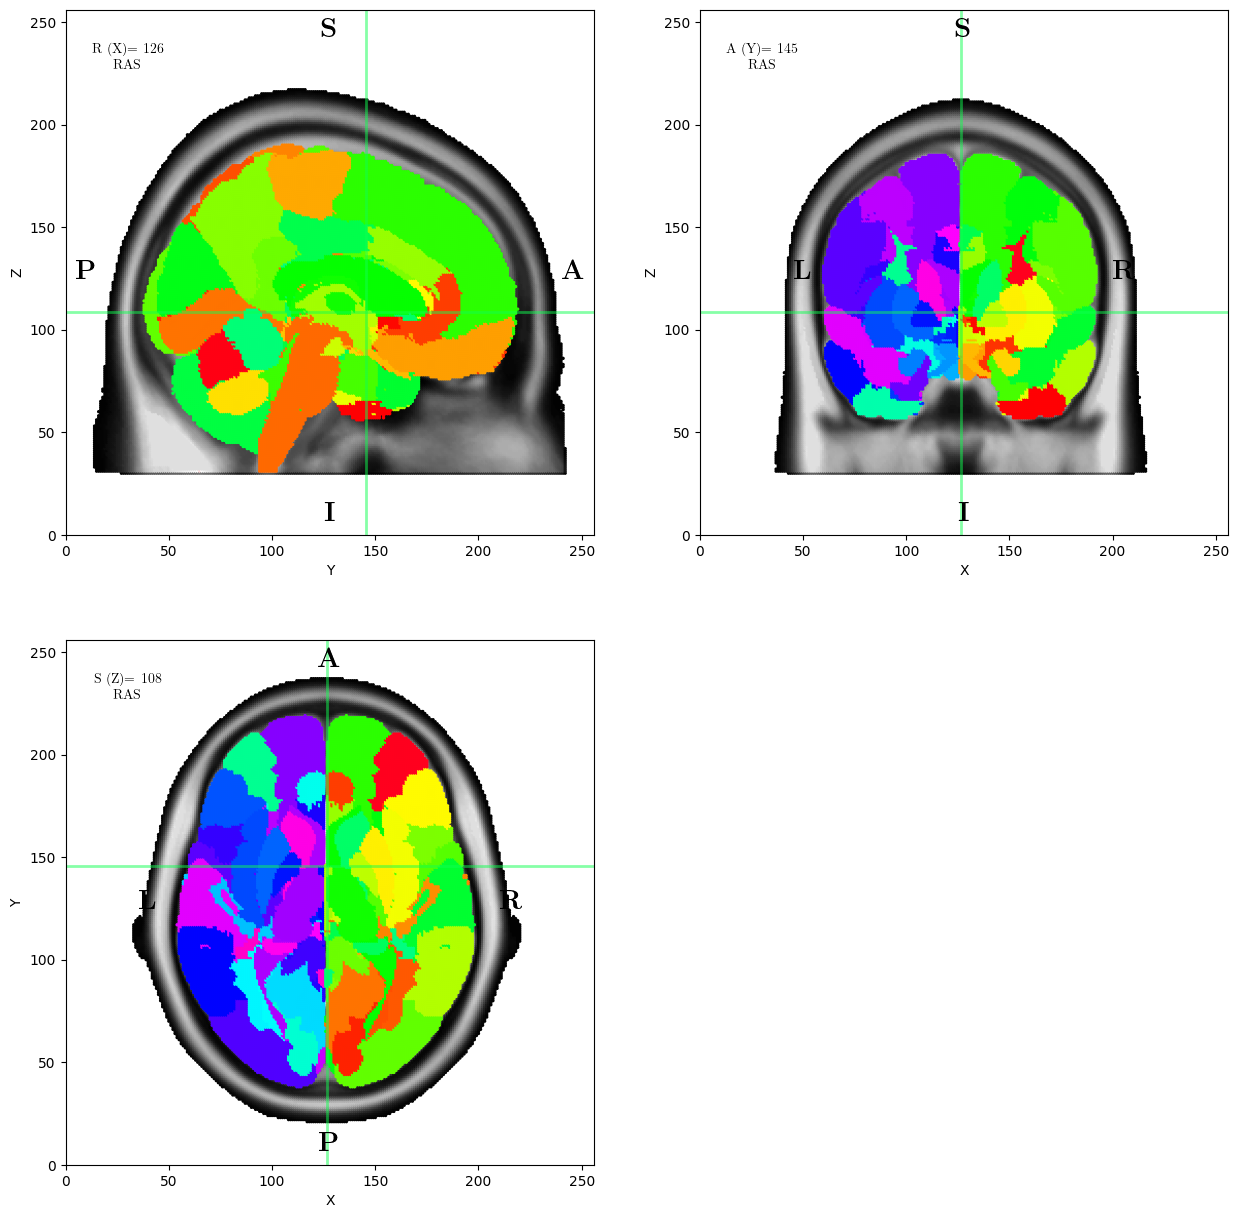

In [13]:
t1_volume, t1_affine = get_volume_ras(f"{CEREBRA_DATA_ICBM152_DIR}/mri/T1.mgz")
cerebra_volume, cerebra_affine = get_volume_ras(f"{CEREBRA_DATA_DIR}/CerebrA_in_t1.mgz")

from cerebra_atlas_python.plotting import orthoview

fig, axs = orthoview(t1_volume, t1_affine, cmap_name="gray", plot_affine=True, narrow_ax=False)
orthoview(cerebra_volume, cerebra_affine,fig=fig, axs=axs, adjust_ax=False, add_coordinate_frame_info=False, add_top_left_info=False)

# 3) Process region metadata

In [14]:
import pandas as pd
from cerebra_atlas_python.plotting import get_cmap_colors_hex
def preprocess_label_details(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the given dataframe by performing several operations such as removing rows and columns,
    converting data types, duplicating and modifying data, and appending new information.

    Args:
        df (pd.DataFrame): The dataframe to preprocess.

    Returns:
        pd.DataFrame: The preprocessed dataframe.
    """
    # Remove first row
    df.drop(0, inplace=True)

    # Remove unused columns
    df.drop(columns=["Unnamed: 3", "Notes", "Dice Kappa"], inplace=True)

    # Change id column from string to int
    df["CerebrA ID"] = pd.to_numeric(df["CerebrA ID"])
    df["CerebrA ID"] = df["CerebrA ID"].astype("uint8")

    # Copy df and append
    df = pd.concat([df, df])
    df.reset_index(inplace=True, drop=True)

    # Modify left side labels
    df.loc["51":, "CerebrA ID"] = df.loc["51":, "CerebrA ID"] + 51

    # df["Mindboggle ID"] = df["Mindboggle ID"].astype("uint16")

    # Modify names to include hemisphere
    df["hemisphere"] = ""
    # df.loc[:, "hemisphere"] = 12
    df.loc["51":, "hemisphere"] = "Left"
    df.loc[:"50", "hemisphere"] = "Right"

    # Label cortical regions
    df["cortical"] = df["Mindboggle ID"] > 1000

    # Adjust Mindboggle ids
    # (see https://mindboggle.readthedocs.io/en/latest/labels.html)
    mask = df["cortical"] & (df["hemisphere"] == "Left")
    df.loc[mask, "Mindboggle ID"] = df.loc[mask, "Mindboggle ID"] - 1000

    # Add white matter to label details
    df.loc[len(df.index)] = [0, "White matter", 103, pd.NA, pd.NA]

    # Add 'empty' to label details
    df.loc[len(df.index)] = [0, "Empty", 0, pd.NA, pd.NA]

    df.sort_values(by=["CerebrA ID"], inplace=True)
    df.reset_index(inplace=True, drop=True)

    # Add hemispheresget_label

    # Add colors
    # Order by CerebrA ID then get colors
    df["color"] = get_cmap_colors_hex()

    return df


def get_label_details(path):
    """Reads a CSV file from the given path and preprocesses its contents using the preprocess_label_details function.
    Returns:
        pd.DataFrame: The preprocessed dataframe obtained from the CSV file.
    """
    return preprocess_label_details(pd.read_csv(path))

In [15]:
label_details_path = op.join(CEREBRA_DIR, "CerebrA_LabelDetails.csv")
processed_label_details = get_label_details(label_details_path)
processed_label_details.to_csv(LABEL_DETAILS_PATH)
processed_label_details

,Mindboggle ID,Label Name,CerebrA ID,hemisphere,cortical,color
0,0.0,Empty,0,NaN,NaN,#000000
1,2027.0,Rostral Middle Frontal,1,Right,True,#ff001e
2,631.0,Vermal lobules VI-VII,2,Right,False,#ff0013
3,2009.0,Inferior temporal,3,Right,True,#ff0003
4,58.0,Accumbens Area,4,Right,False,#ff0700
...,...,...,...,...,...,...
99,53.0,Hippocampus,99,Left,False,#ff00f0
100,50.0,Caudate,100,Left,False,#ff00e5
101,630.0,Vermal lobules I-V,101,Left,False,#ff00d4
102,1031.0,Supramarginal,102,Left,True,#ff00ca
